# Import data

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import gc
from copy import deepcopy
import re
from tqdm.auto import tqdm

from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsNERTagger,
    Doc
)

In [2]:
df = pd.read_parquet("../Data/trading_data_after_eda_5years.parquet")

In [3]:
print(df.shape)
df

(169848, 8)


,website,section,url,header,body,key_words,body_length,datetime
0,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/644973,"Нефть Brent подешевела до $54,25 за баррель",- Цены на нефть снижаются в четверг после по...,[Brent],2101,2019-01-03 09:38:00
1,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/644976,Рынок акций РФ открылся снижением индексов Мос...,- Рынок акций РФ на первых в новом году торг...,[рынок акций],1961,2019-01-03 10:18:00
2,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/644980,Доллар в моменте обновил максимум марта 2016 г...,"По данным аналитиков, доллар вырос из-за разов...","[курсы валют, рубль, евро, доллар]",1048,2019-01-03 10:42:00
3,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514388.php,Банк Открытие и Бинбанк - процесс объединения ...,"Банк ""ФК Открытие"" и Бинбанк — завершили проце...","[ФК Открытие, Бинбанк, Открытие]",882,2019-01-03 11:24:00
4,Ria,Экономика,https://ria.ru/20190103/1549006636.html,Рубль открыл год ростом к доллару и евро,Рубль открыл первые торги нового года уверен...,"[Экономика, Россия]",375,2019-01-03 11:49:00
...,...,...,...,...,...,...,...,...
169843,Kommersant,Финансы,https://www.kommersant.ru/doc/6440789,ЦБ изучит связанные с криптоактивами трансгран...,Банк России планирует в начале 2024 года изучи...,[],1529,2023-12-29 20:52:00
169844,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938589,JD.com выиграла антимонопольное дело против ко...,- Китайская интернет-компания JD.com Inc. вы...,"[Alibaba, JD.com, Tmall, Китай]",675,2023-12-29 20:52:00
169845,Ria,Экономика,https://ria.ru/20231229/ssha-1919057051.html,"В США призвали ставить маячки на оборудование,...",Два американских эксперта в статье для New Y...,"[Экономика, Китай, США, Технологии, Россия, Ap...",1773,2023-12-29 21:00:00
169846,Ria,Экономика,https://ria.ru/20231229/kapital-1919057431.html,"Глава ""Иннопрактики"" и ее первый зам вошли в к...","Глава российского института развития ""Иннопр...","[Экономика, Технологии, Россия, Наталия Попова...",2063,2023-12-29 21:01:00


# Create verification dict

---
**Sources:** 
* Companies: 
    - broad market index base [MOEXBMI](https://fin-plan.org/lk/index/MOEXBMI/) 
    - database of 10 [industry indices](https://www.moex.com/ru/index/MOEXOG) 
* Industries: 
    - according to 10 existing [industry indices](https://www.moex.com/ru/index/MOEXOG)
* Global: 
    - state entities: common sense :) 
    - politicians: top 50 from [here](http://www.apecom.ru/projects/item.php?SECTION_ID=100&ELEMENT_ID=8915)
    
---
    
**Forms in the dictionary:**
* Companies: 
    - standard name 
    - abbreviation 
    - name in English 
    - ticker on the market 
* Industries: 
    - determined by the company’s belonging to a certain industry 
* Global: 
    - State entities: frequently used variations (i.e. CB, Central Bank, Central Bank of Russia, etc.) 
    - Politicians: surnames
---

In [4]:
companies = {
    # One
    'SBER': r'\s(?:сбербанк|сбер|sber|sberbank)\s',
    'LKOH': r'\s(:?лукойл|lukoil|lkoh)\s',
    'GAZP': r'\s(:?газпром|gazprom|gazp)\s',
    'GMKN':
    r'\s(:?норильский никель|норникель|gmkn|nornikel|гмкнорник|норник)\s',
    'NVTK': r'\s(:?новатэк|novatek|nvtk)\s',
    'YNDX': r'\s(:?яндекс|yandex|yndx|янд)\s',
    'ROSN': r'\s(:?роснефть|rosn|rosneft)\s',
    'TATN': r'\s(:?татнефть|татнфт|tatn|tatneft)\s',
    'MGNT': r'\s(:?магнит|mgnt|magnit)\s',
    'TCSG': r'\s(:?tcg|tcs|tcsg|тиньк|тинькофф|тиньков)\s',
    # Two
    'SNGS': r'\s(:?сургутнефтегаз|сургнфгз|sngs|surgutneftegas)\s',
    'TRNF': r'\s(:?транснефть|транснф|trnf|transneft)\s',
    'PLZL': r'\s(:?полюс|plzl|polus zoloto|polus)\s',
    'CHMF': r'\s(:?северсталь|севст|chmf|severstal)\s',
    'FIVE': r'\s(:?x5|five)\s',
    'NLMK':
    r'\s(:?нлмк|nlmk|новолипецкий металлургический комбинат|новолипецкий)\s',
    'MTSS': r'\s(:?мтс|мобильные телесистемы|mts|mtss)\s',
    # Three
    'PHOR': r'\s(:?фосагро|phor|phosagro)\s',
    'POLY': r'\s(:?полиметалл|polymetal|poly)\s',
    'ALRS': r'\s(:?алроса|alrs|alrosa)\s',
    'IRAO': r'\s(:?интеррао|интер рао|irao|inter rao|interrao)\s',
    'OZON': r'\s(:?ozon|озон)\s',
    'MAGN': r'\s(:?магнитогорский металлургический комбинат|ммк|magn|mmk)\s',
    'VTBR': r'\s(:?втб|vtb|vtbr)\s',
    'HHRU': r'\s(:?headhunter|hh|hhru|хэдхантер|хэдхантэр)\s',
    'RUAL': r'\s(:?русал|rusal|rual)\s',
    'PIKK': r'\s(:?пик|pikk|pik)\s',
    # Four
    'ENPG': r'\s(:?эн\+ груп|en\+ group|эн\+|en\+|эн\+груп|enpg|en\+group)\s',
    'RTKM': r'\s(:?ростелеком|ростел|rostel|rostelecom|rtkm)\s',
    'MTLR': r'\s(:?мечел|mechel|mltr)\s',
    'FIXP': r'\s(:?fix|fix price|fixp|фикс прайс)\s',
    'GLTR': r'\s(:?globaltrans|gltr|глобалтранс|global trans|глобал транс)\s',
    'CBOM': r'\s(:?московский кредитный банк|мкб|mkb|московский банк|cbom)\s',
    'HYDR': r'\s(:?русгидро|hydr|rushydro)\s',
    'AGRO': r'\s(:?русагро|agro|rusagro)\s',
    'AFKS': r'\s(:?афк система|афк|afks|afk|afk system)\s',
    # Five
    'BANE': r'\s(:?башнефт|башнефть|bane|bashneft)\s',
    'KAZT': r'\s(:?куйбазот|куйбышевазот|kazt)\s',
    'FLOT': r'\s(:?совкомфлот|sovkomflot|flot)\s',
    'FEES': r'\s(:?фск россети|fees|fsk rosseti)\s',
    'VSMO': r'\s(:?всмпо-авсм|всмпо|авсм|vsmpo|avsm|vsmpo-avsm|vsmo)\s',
    'AFLT': r'\s(:?аэрофлот|aflt|aeroflot)\s',
    'AKRN': r'\s(:?акрон|akrn|akron)\s',
    'SELG': r'\s(:?селигдар|selg|seligdar)\s',
    'NKNC': r'\s(:?нкнх|нижнекамскнефтехим|nknc)\s',
    # Six
    'BSPB': r'\s(:?бсп|банк санкт-петербург|банк спб|bspb|bsp)\s',
    'LENT': r'\s(:?лента|lenta|lent)\s',
    'GEMC': r'\s(:?gemc|united medical)\s',
    'KZOS': r'\s(:?казаньоргсинтез|оргсинт|kzos|kazanorgsintez)\s',
    'MGTS': r'\s(:?мгтс|mgts|московская городская телефонная сеть)\s',
    'MSNG': r'\s(:?мосэнерго|\+мосэнерго|mosenergo|\+mosenergo|msng)\s',
    'SMLT': r'\s(:?гк самолет|smlt|gk samolet)\s',
    'NMTP': r'\s(:?нмтп|nmtp|новороссийский морской торговый порт)\s',
    'UPRO': r'\s(:?юнипро|upro|unipro)\s',
    'FESH': r'\s(:?двмп|fesh|дальневосточное морское пароходство|dvmp)\s',
    # Seven
    'BELU': r'\s(:?новабев|belu|novabev)\s',
    'QIWI': r'\s(:?qiwi|киви|iqiwi|айкиви)\s',
    'MDMG': r'\s(:?mdmg|md medical)\s',
    'POSI': r'\s(:?iпозитив|группа позитив|ipositiv|positiv|posi)\s',
    'RASP': r'\s(:?распадская|raspadskaya|rasp)\s',
    'LSRG': r'\s(:?лср|группа лср|lsr|lsrg)\s',
    'LSNG': r'\s(:?россети ленэнерго|ленэнерго|lenenergo|lsng)\s',
    'SGZH': r'\s(:?сегежа|segezha|sgzh)\s',
    # Eight
    'RSTI': r'\s(:?rsti|российские сети|россети|rosseti)\s',
    'OGKB': r'\s(:?огк-2|ogk-2|ogkb)\s',
    'AQUA': r'\s(:?инарктика|aqua|inarctica)\s',
    'ETLN': r'\s(:?etalon|etln|группа эталон|эталон)\s',
    'RENI': r'\s(:?ренессанс страхование|группа ренессанс|reni)\s',
    'NKHP': r'\s(:?нкхп|nkhp|новороссийский комбинат хлебопродуктов)\s',
    'MRKP': r'\s(:?рсетицп|россети центр и приволжье|mrkp)\s',
    'MRKC': r'\s(:?россцентр|россети центр|mrkc)\s',
    'MVID': r'\s(:?м\.видео|мвидео|mvideo|m\.video|mvid)\s',
    'ELFV': r'\s(:?эл5-энерго|эл5энер|эл5|el5ener|el5-energo|el5|elfv)\s',
    # Nine
    'TGKA': r'\s(:?тгк-1|tgka|tgk-1)\s',
    'RNFT': r'\s(:?русснфт|русснефть|rnft|russneft|russnft)\s',
    'APTK': r'\s(:?аптеки36и6|аптечная сеть 36,6|aptk)\s',
    'MSRS': r'\s(:?рсетимр|россети московский регион|msrs|rsetimr)\s',
    'SFIN': r'\s(:?эсэфай|sfi|сафмар|sfin)\s',
    'MRKU': r'\s(:?россети урал|россети ур|rosseti ural|rosseti ur|mrku)\s',
    'SVAV': r'\s(:?соллерс|sollers|svav)\s',
    'CIAN': r'\s(:?циан|cian)\s',
    'TGKB': r'\s(:?тгк-2|tgkb|tgk-2)\s',
    # Ten
    'DVEC': r'\s(:?дэк|дальневосточная энергетическая компания|dec|dvec)\s',
    'RKKE': r'\s(:?энергияркк|ркк энергия|rkk energia|rkk energiya|rkke)\s',
    'MRKZ': r'\s(:?рсетисз|россети северо-запад|mrkz)\s',
    'WUSH': r'\s(:?iвушхолднг|вуш|wush|whoosh)\s',
    'TTLK': r'\s(:?таттел|таттелеком|ttlk|tattelecom|tattel)\s',
    'MRKV': r'\s(:?рсетвол|россети волга|mrkv)\s',
    'ABIO': r'\s(:?iартген|артген|abio|artgen)\s',
    'CHMK': r'\s(:?чмк|челябинский металлургический комбинат|chmk)\s',
    'OKEY': r"\s(:?okey|o'key|окей|о'кей)\s",

    # More
    'VKCO': r'\s(:?вк|vk|вконтакте|vkontakte|в контакте|v kontakte|vkco)\s'
}

industries = {
    # Нефть и газ
    'MOEXOG':
    ['BANE', 'GAZP', 'LKOH', 'NVTK', 'RNFT', 'ROSN', 'SNGS', 'TATN', 'TRNF'],
    # Электроэнергетики
    'MOEXEU': [
        'IRAO', 'HYDR', 'FEES', 'MSNG', 'UPRO', 'LSNG', 'RSTI', 'OGKB', 'MRKP',
        'MRKC', 'ELFV', 'TGKA', 'MSRS', 'MRKU', 'TGKB', 'DVEC', 'MRKZ', 'MRKV'
    ],
    # Телекоммуникации
    'MOEXTL': ['MTSS', 'RTKM', 'MGTS', 'TTLK'],
    # Металлы и добыча
    'MOEXMM': [
        'GMKN', 'PLZL', 'CHMF', 'NLMK', 'POLY', 'ALRS', 'MAGN', 'RUAL', 'ENPG',
        'MTLR', 'VSMO', 'SELG', 'RASP', 'SGZH', 'CHMK'
    ],
    # Финансы
    'MOEXFN':
    ['SBER', 'TCSG', 'VTBR', 'CBOM', 'BSPB', 'QIWI', 'RENI', 'SFIN', 'AFKS'],
    # Потребительский сектор
    'MOEXCN': [
        'MGNT', 'FIVE', 'FIXP', 'AGRO', 'GEMC', 'LENT', 'BELU', 'MDMG', 'AQUA',
        'MVID', 'APTK', 'SVAV', 'WUSH', 'ABIO', 'OKEY'
    ],
    # Химия и нефтехимия
    'MOEXCH': ['PHOR', 'KAZT', 'AKRN', 'NKNC', 'KZOS'],
    # Транспорт
    'MOEXTN': ['GLTR', 'FLOT', 'AFLT', 'NMTP', 'FESH', 'NKHP', 'RKKE'],
    # Информационные технологии
    'MOEXIT': ['CIAN', 'HHRU', 'OZON', 'POSI', 'VKCO', 'YNDX'],
    # Строительные компании
    'MOEXRE': ['ETLN', 'LSRG', 'PIKK', 'SMLT'],
}

politicians = {
    # One
    'путин': r'путин',
    'мишустин': r'мишустин',
    'вайно': r'вайно',
    'медведев': r'медведев',
    'собянин': r'собянин',
    'кириенко': r'кириенко',
    'лавров': r'лавров',
    'патрушев': r'патрушев',
    'шойгу': r'шойгу',
    'миллер': r'миллер',
    # Two
    'сечин': r'сечин',
    'силуанов': r'силуанов',
    'громов': r'громов',
    'набиуллина': r'набиуллина',
    'турчак': r'турчак',
    'бортников': r'бортников',
    'володин': r'володин',
    'песков': r'песков',
    'бастрыкин': r'бастрыкин',
    'белоусов': r'белоусов',
    # Three
    'нарышкин': r'нарышкин',
    'чемезов': r'чемезов',
    'матвиенко': r'матвиенко',
    'греф': r'греф',
    'золотов': r'золотов',
    'колокольцев': r'колокольцев',
    'тимченко': r'тимченко',
    'ковальчук': r'ковальчук',
    'патриарх': r'патриарх',
    'хуснуллин': r'хуснуллин',
    # Four
    'борисов': r'борисов',
    'голикова': r'голикова',
    'новак': r'новак',
    'герасимов': r'герасимов',
    'костин': r'костин',
    'козак': r'козак',
    'патрушев': r'патрушев',
    'чернышенко': r'чернышенко',
    'ярин': r'ярин',
    'мантуров': r'мантуров',
    # Five
    'трутнев': r'трутнев',
    'григоренко': r'григоренко',
    'левитин': r'левитин',
    'краснов': r'краснов',
    'усманов': r'усманов',
    'васильев': r'васильев',
    'оверчук': r'оверчук',
    'ротенберг': r'ротенберг',
    'харичев': r'харичев',
    'чиханчин': r'чиханчин',
}

federal_instances = {
    "ЦБ":
    r'\s(?:цб|центральный банк|центробанк)\s',
    "МинФин":
    r'\s(?:министерство финансов|минфин)\s',
    "ФНС":
    r'\s(?:федеральная налоговая служба|фнс|налоговая служба|налоговый департамент|налоговое ведомство|налоговое управление)\s',
    "ФСФМ":
    r'\s(?:федеральная служба финансового мониторинга|финмониторинг|федеральная служба по финансовым операциям|фсфм)\s',
    "ПФР":
    r'\s(?:пенсионный фонд|пфр|фонд пенсионного обеспечения|фонд соцзащиты)\s',
    "ФНБ":
    r'\s(?:фонд национального благосостояния|фнб|фонд стабилизации|фонд)\s',
    "ФК":
    r'\s(?:казначейство|фк|финансовая служба)\s',
    "ММВБ":
    r'\s(?:ммвб|московская биржа|moex|rts|российская торговая система|биржевой индекс)\s',
}

# Extract NER

In [5]:
# Natasha <3
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

ner_tagger = NewsNERTagger(emb)

In [8]:
tokens_lst = []
docs_lst = [Doc(text) for text in df['body']]
LEN = 1000
EPOCH = 170

for i in tqdm(range(EPOCH)):
    
    temp = [deepcopy(el) for el in docs_lst[LEN*i:LEN*i+LEN]]
    
    for doc in temp:
        doc.segment(segmenter)

        doc.tag_morph(morph_tagger)

        for token in doc.tokens:
            token.lemmatize(morph_vocab)

        doc.tag_ner(ner_tagger)

        for span in doc.spans:
            span.normalize(morph_vocab)

        tokens_lst.append(list(set([i.normal for i in doc.spans])))
    
    del temp
    gc.collect()

# Filter NE found

In [21]:
def filter_ne(lst: list, filt: dict) -> None:
    for tokens in tqdm(tokens_lst):
        help_lst = []
        for key, pattern in filt.items():
            obj = re.search(pattern, '   '.join(tokens).lower())
            if obj:
                help_lst.append(key)

        lst.append(help_lst)

In [6]:
companies_lst = []
fed_and_polit_lst = []

filter_ne(companies_lst, companies)
filter_ne(fed_and_polit_lst, federal_instances | politicians)
    
# print(len([lst for lst in companies_lst if (len(lst) > 0) and (len(lst) <= 10)]))
# print(len([lst for lst in fed_and_polit_lst if len(lst) > 0]))

In [7]:
data = pd.DataFrame(columns=[*df.columns, "companies", "fed_and_polit"])
rows_to_insert = []

for i in tqdm(range(df.shape[0])):
    if (len(companies_lst[i]) != 0) or (len(fed_and_polit_lst[i]) != 0):
        rows_to_insert.append(
            {
                'website': df.loc[i, 'website'], 
                'section': df.loc[i, 'section'],
                'url': df.loc[i, 'url'],
                'header': df.loc[i, 'header'],
                'body': df.loc[i, 'body'],
                'key_words': df.loc[i, 'key_words'],
                'body_length': df.loc[i, 'body_length'],
                'datetime': df.loc[i, 'datetime'],
                'companies': companies_lst[i],
                'fed_and_polit': fed_and_polit_lst[i]
            }
        ) 

data = pd.concat([data, pd.DataFrame(rows_to_insert)], ignore_index=True)

# Final Datasets

## Companies dataset

In [59]:
comp_df = data[data['companies'].apply(lambda x: len(x) != 0)].reset_index()

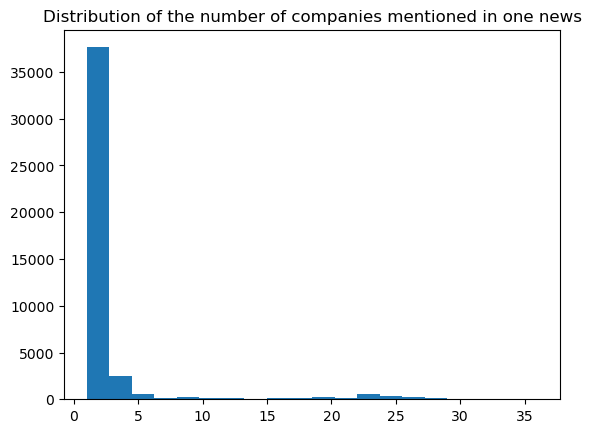

In [61]:
lst_len = []
for i in range(len(comp_df)):
    lst_len.append(len(comp_df.loc[i,'companies']))

plt.hist(lst_len, bins=20)
plt.title('Distribution of the number of companies mentioned in one news')
plt.show()

> **Comment**: You may notice that we have news where 20-30 companies are mentioned, these news are market reviews and are not suitable for our purposes, so we will not include them in our final dataset of companies and industries

In [63]:
final_comp_df = pd.DataFrame(columns=[*df.columns, 'company'])
rows_to_insert = []

for i in tqdm(range(len(comp_df))):
    if len(comp_df.loc[i,'companies']) <= 10:
        for company in comp_df.loc[i,'companies']:
            rows_to_insert.append(
                {
                    'website': comp_df.loc[i, 'website'], 
                    'section': comp_df.loc[i, 'section'],
                    'url': comp_df.loc[i, 'url'],
                    'header': comp_df.loc[i, 'header'],
                    'body': comp_df.loc[i, 'body'],
                    'key_words': comp_df.loc[i, 'key_words'],
                    'body_length': comp_df.loc[i, 'body_length'],
                    'datetime': comp_df.loc[i, 'datetime'],
                    'company': company,

                }
            )

final_comp_df = pd.concat([final_comp_df, pd.DataFrame(rows_to_insert)], ignore_index=True)

  0%|          | 0/43430 [00:00<?, ?it/s]

In [65]:
print(final_comp_df.shape)
final_comp_df

(57968, 9)


,website,section,url,header,body,key_words,body_length,datetime,company
0,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,SBER
1,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,VTBR
2,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,AFLT
3,Ria,Экономика,https://ria.ru/20190103/1549008662.html,"""Дочка"" Сбербанка назвала штраф украинского ЦБ...","Украинская ""дочка"" Сбербанка назвала штраф Н...","[Экономика, Реакция на события на Украине, Сбе...",1003,2019-01-03 13:31:00,SBER
4,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514416.php,Газпром - Северный поток-2 заработает с 1 янва...,"Глава ""Газпрома"" Алексей Миллер рассказал в ин...","[Газпром, Северный поток-2]",470,2019-01-03 13:57:00,GAZP
...,...,...,...,...,...,...,...,...,...
57963,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/974719.php,C 3 января 2024 ГДР UNITED MEDICAL GROUP на Мо...,В связи с государственной регистрацией 29 дека...,"[акции, EMC, UNITED MEDICAL GROUP]",1723,2023-12-29 18:30:00,GEMC
57964,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938588,Сооснователь Fix Price Хачатрян продал свою до...,- Сооснователь Fix Price Артем Хачатрян выше...,"[Fix Price, Артем Хачатрян]",1302,2023-12-29 19:24:00,FIXP
57965,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/974755.php,ЛСР выкупила свои акции у Арсагеры стоимостью ...,В ЛСР вышло 4 сущ. факта о покупке своих акций...,"[акции, Группа ЛСР]",656,2023-12-29 20:07:00,LSRG
57966,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938598,"ЦБ РФ оценит трансграничные переводы физлиц, с...",- Банк России в январе-феврале 2024 года про...,"[ЦБ РФ, Банк России]",1401,2023-12-29 20:41:00,QIWI


## Industries dataset

In [67]:
ind_df = pd.DataFrame(columns=[*df.columns, 'industry'])
rows_to_insert = []

for i in tqdm(range(len(comp_df))):
    if len(comp_df.loc[i,'companies']) <= 10:  
        ind_lst = []
        for company in comp_df.loc[i,'companies']: 
            for industry, ind_companies in industries.items():
                if company in ind_companies and industry not in ind_lst:
                    ind_lst.append(industry)

                    rows_to_insert.append(
                        {
                        'website': comp_df.loc[i, 'website'], 
                        'section': comp_df.loc[i, 'section'],
                        'url': comp_df.loc[i, 'url'],
                        'header': comp_df.loc[i, 'header'],
                        'body': comp_df.loc[i, 'body'],
                        'key_words': comp_df.loc[i, 'key_words'],
                        'body_length': comp_df.loc[i, 'body_length'],
                        'datetime': comp_df.loc[i, 'datetime'],
                        'industry': industry,
                        }
                    ) 
                
ind_df = pd.concat([ind_df, pd.DataFrame(rows_to_insert)], ignore_index=True)

  0%|          | 0/43430 [00:00<?, ?it/s]

In [69]:
print(ind_df.shape)
ind_df

(48270, 9)


,website,section,url,header,body,key_words,body_length,datetime,industry
0,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,MOEXFN
1,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,MOEXTN
2,Ria,Экономика,https://ria.ru/20190103/1549008662.html,"""Дочка"" Сбербанка назвала штраф украинского ЦБ...","Украинская ""дочка"" Сбербанка назвала штраф Н...","[Экономика, Реакция на события на Украине, Сбе...",1003,2019-01-03 13:31:00,MOEXFN
3,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514416.php,Газпром - Северный поток-2 заработает с 1 янва...,"Глава ""Газпрома"" Алексей Миллер рассказал в ин...","[Газпром, Северный поток-2]",470,2019-01-03 13:57:00,MOEXOG
4,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514430.php,ФГ Будущее - продала пенсионный бизнес,Финансовая группа Будущее продала свой пенсион...,"[ФГ будущее, НПФ]",666,2019-01-03 15:37:00,MOEXFN
...,...,...,...,...,...,...,...,...,...
48265,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/974719.php,C 3 января 2024 ГДР UNITED MEDICAL GROUP на Мо...,В связи с государственной регистрацией 29 дека...,"[акции, EMC, UNITED MEDICAL GROUP]",1723,2023-12-29 18:30:00,MOEXCN
48266,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938588,Сооснователь Fix Price Хачатрян продал свою до...,- Сооснователь Fix Price Артем Хачатрян выше...,"[Fix Price, Артем Хачатрян]",1302,2023-12-29 19:24:00,MOEXCN
48267,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/974755.php,ЛСР выкупила свои акции у Арсагеры стоимостью ...,В ЛСР вышло 4 сущ. факта о покупке своих акций...,"[акции, Группа ЛСР]",656,2023-12-29 20:07:00,MOEXRE
48268,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938598,"ЦБ РФ оценит трансграничные переводы физлиц, с...",- Банк России в январе-феврале 2024 года про...,"[ЦБ РФ, Банк России]",1401,2023-12-29 20:41:00,MOEXFN


## Global dataset

In [70]:
global_df = data.drop(['companies'], axis=1).copy()

In [72]:
print(global_df.shape)
global_df

(84521, 8)


,website,section,url,header,body,key_words,body_length,datetime
0,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/644976,Рынок акций РФ открылся снижением индексов Мос...,- Рынок акций РФ на первых в новом году торг...,[рынок акций],1961,2019-01-03 10:18:00
1,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00
2,Ria,Экономика,https://ria.ru/20190103/1549008662.html,"""Дочка"" Сбербанка назвала штраф украинского ЦБ...","Украинская ""дочка"" Сбербанка назвала штраф Н...","[Экономика, Реакция на события на Украине, Сбе...",1003,2019-01-03 13:31:00
3,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514416.php,Газпром - Северный поток-2 заработает с 1 янва...,"Глава ""Газпрома"" Алексей Миллер рассказал в ин...","[Газпром, Северный поток-2]",470,2019-01-03 13:57:00
4,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514430.php,ФГ Будущее - продала пенсионный бизнес,Финансовая группа Будущее продала свой пенсион...,"[ФГ будущее, НПФ]",666,2019-01-03 15:37:00
...,...,...,...,...,...,...,...,...
84516,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938598,"ЦБ РФ оценит трансграничные переводы физлиц, с...",- Банк России в январе-феврале 2024 года про...,"[ЦБ РФ, Банк России]",1401,2023-12-29 20:41:00
84517,Kommersant,Финансы,https://www.kommersant.ru/doc/6440789,ЦБ изучит связанные с криптоактивами трансгран...,Банк России планирует в начале 2024 года изучи...,[],1529,2023-12-29 20:52:00
84518,Ria,Экономика,https://ria.ru/20231229/ssha-1919057051.html,"В США призвали ставить маячки на оборудование,...",Два американских эксперта в статье для New Y...,"[Экономика, Китай, США, Технологии, Россия, Ap...",1773,2023-12-29 21:00:00
84519,Ria,Экономика,https://ria.ru/20231229/kapital-1919057431.html,"Глава ""Иннопрактики"" и ее первый зам вошли в к...","Глава российского института развития ""Иннопр...","[Экономика, Технологии, Россия, Наталия Попова...",2063,2023-12-29 21:01:00


# Export data

In [76]:
final_comp_df.to_parquet('../Data/comp_data_after_ner_5years.parquet', index=False)

In [77]:
ind_df.to_parquet('../Data/ind_data_after_ner_5years.parquet', index=False)

In [78]:
global_df.to_parquet('../Data/glob_data_after_ner_5years.parquet', index=False)

In [79]:
pd.read_parquet('../Data/comp_data_after_ner_5years.parquet')

,website,section,url,header,body,key_words,body_length,datetime,company
0,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,SBER
1,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,VTBR
2,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,AFLT
3,Ria,Экономика,https://ria.ru/20190103/1549008662.html,"""Дочка"" Сбербанка назвала штраф украинского ЦБ...","Украинская ""дочка"" Сбербанка назвала штраф Н...","[Экономика, Реакция на события на Украине, Сбе...",1003,2019-01-03 13:31:00,SBER
4,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514416.php,Газпром - Северный поток-2 заработает с 1 янва...,"Глава ""Газпрома"" Алексей Миллер рассказал в ин...","[Газпром, Северный поток-2]",470,2019-01-03 13:57:00,GAZP
...,...,...,...,...,...,...,...,...,...
57963,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/974719.php,C 3 января 2024 ГДР UNITED MEDICAL GROUP на Мо...,В связи с государственной регистрацией 29 дека...,"[акции, EMC, UNITED MEDICAL GROUP]",1723,2023-12-29 18:30:00,GEMC
57964,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938588,Сооснователь Fix Price Хачатрян продал свою до...,- Сооснователь Fix Price Артем Хачатрян выше...,"[Fix Price, Артем Хачатрян]",1302,2023-12-29 19:24:00,FIXP
57965,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/974755.php,ЛСР выкупила свои акции у Арсагеры стоимостью ...,В ЛСР вышло 4 сущ. факта о покупке своих акций...,"[акции, Группа ЛСР]",656,2023-12-29 20:07:00,LSRG
57966,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938598,"ЦБ РФ оценит трансграничные переводы физлиц, с...",- Банк России в январе-феврале 2024 года про...,"[ЦБ РФ, Банк России]",1401,2023-12-29 20:41:00,QIWI


In [80]:
pd.read_parquet('../Data/ind_data_after_ner_5years.parquet')

,website,section,url,header,body,key_words,body_length,datetime,industry
0,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,MOEXFN
1,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00,MOEXTN
2,Ria,Экономика,https://ria.ru/20190103/1549008662.html,"""Дочка"" Сбербанка назвала штраф украинского ЦБ...","Украинская ""дочка"" Сбербанка назвала штраф Н...","[Экономика, Реакция на события на Украине, Сбе...",1003,2019-01-03 13:31:00,MOEXFN
3,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514416.php,Газпром - Северный поток-2 заработает с 1 янва...,"Глава ""Газпрома"" Алексей Миллер рассказал в ин...","[Газпром, Северный поток-2]",470,2019-01-03 13:57:00,MOEXOG
4,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514430.php,ФГ Будущее - продала пенсионный бизнес,Финансовая группа Будущее продала свой пенсион...,"[ФГ будущее, НПФ]",666,2019-01-03 15:37:00,MOEXFN
...,...,...,...,...,...,...,...,...,...
48265,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/974719.php,C 3 января 2024 ГДР UNITED MEDICAL GROUP на Мо...,В связи с государственной регистрацией 29 дека...,"[акции, EMC, UNITED MEDICAL GROUP]",1723,2023-12-29 18:30:00,MOEXCN
48266,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938588,Сооснователь Fix Price Хачатрян продал свою до...,- Сооснователь Fix Price Артем Хачатрян выше...,"[Fix Price, Артем Хачатрян]",1302,2023-12-29 19:24:00,MOEXCN
48267,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/974755.php,ЛСР выкупила свои акции у Арсагеры стоимостью ...,В ЛСР вышло 4 сущ. факта о покупке своих акций...,"[акции, Группа ЛСР]",656,2023-12-29 20:07:00,MOEXRE
48268,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938598,"ЦБ РФ оценит трансграничные переводы физлиц, с...",- Банк России в январе-феврале 2024 года про...,"[ЦБ РФ, Банк России]",1401,2023-12-29 20:41:00,MOEXFN


In [81]:
pd.read_parquet('../Data/glob_data_after_ner_5years.parquet')

,website,section,url,header,body,key_words,body_length,datetime
0,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/644976,Рынок акций РФ открылся снижением индексов Мос...,- Рынок акций РФ на первых в новом году торг...,[рынок акций],1961,2019-01-03 10:18:00
1,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/643817,Экстренная посадка в регионах,Итоги года на российском авиарынке\nМосква. 3 ...,"[Аэрофлот, ВТБ, Победа, итоги года]",11805,2019-01-03 13:00:00
2,Ria,Экономика,https://ria.ru/20190103/1549008662.html,"""Дочка"" Сбербанка назвала штраф украинского ЦБ...","Украинская ""дочка"" Сбербанка назвала штраф Н...","[Экономика, Реакция на события на Украине, Сбе...",1003,2019-01-03 13:31:00
3,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514416.php,Газпром - Северный поток-2 заработает с 1 янва...,"Глава ""Газпрома"" Алексей Миллер рассказал в ин...","[Газпром, Северный поток-2]",470,2019-01-03 13:57:00
4,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514430.php,ФГ Будущее - продала пенсионный бизнес,Финансовая группа Будущее продала свой пенсион...,"[ФГ будущее, НПФ]",666,2019-01-03 15:37:00
...,...,...,...,...,...,...,...,...
84516,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938598,"ЦБ РФ оценит трансграничные переводы физлиц, с...",- Банк России в январе-феврале 2024 года про...,"[ЦБ РФ, Банк России]",1401,2023-12-29 20:41:00
84517,Kommersant,Финансы,https://www.kommersant.ru/doc/6440789,ЦБ изучит связанные с криптоактивами трансгран...,Банк России планирует в начале 2024 года изучи...,[],1529,2023-12-29 20:52:00
84518,Ria,Экономика,https://ria.ru/20231229/ssha-1919057051.html,"В США призвали ставить маячки на оборудование,...",Два американских эксперта в статье для New Y...,"[Экономика, Китай, США, Технологии, Россия, Ap...",1773,2023-12-29 21:00:00
84519,Ria,Экономика,https://ria.ru/20231229/kapital-1919057431.html,"Глава ""Иннопрактики"" и ее первый зам вошли в к...","Глава российского института развития ""Иннопр...","[Экономика, Технологии, Россия, Наталия Попова...",2063,2023-12-29 21:01:00
